<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель проекта: обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. В распоряжении набор данных с разметкой о токсичности правок.


**Этапы выполнения проекта**

1. Загрузка и подготовка данные.
2. Обучение разных моделей. 
3. Формулирование выводов.


**Описание данных**

Использовались следующие данные: столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import tqdm
import os
import re
import time
import lightgbm
import spacy
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords as nltk_stopwords
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(df.head())
display(df.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Проверим классы на дисбаланс:

In [4]:
print(df['toxic'].value_counts(normalize=True).map('{:.2%}'.format))

0    89.84%
1    10.16%
Name: toxic, dtype: object


Промежуточный вывод: классы не сбалансированы, существена доля нетоксичных комментариев.

Токенизируем, лемматизируем и очистим 1/3 текстового датасета, на которой будет производиться обучение и тестирование с помощью модели "en_core_web_sm" из библиотеки SpaCy:

In [5]:
df = df.iloc[0:50000]

In [6]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

def clear_text(text):
    doc = nlp(text)
    doc = ' '.join([token.lemma_ for token in doc])
    text_only = re.sub(r'[^a-zA-Z]', ' ', doc)
    final = ' '.join(text_only.split())
    return final

In [8]:
tqdm.pandas()
df['text_lemm'] = df['text'].progress_apply(clear_text)

100%|██████████| 50000/50000 [11:30<00:00, 72.44it/s] 


In [10]:
print(df['text_lemm'][0])

Explanation why the edit make under my username Hardcore Metallica Fan be revert they be not vandalism just closure on some gas after I vote at New York Dolls FAC and please do not remove the template from the talk page since I be retire now


In [11]:
df_new = df.drop(columns=['text','Unnamed: 0']).reset_index(drop=True)
display(df_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   toxic      50000 non-null  int64 
 1   text_lemm  50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


None

Промежуточный вывод: В результате подготовки данных был выявлен существенный дисбаланс классов. Одна треть текстовых данных датасета была токенизирована, проведена лемматизация и очистка этих данных с помощью модели "en_core_web_sm" из библиотеки SpaCy.

## Обучение

Разделим датасет на обучающую и тестовую выборки:

In [12]:
RANDOM_STATE = 12345

In [13]:
train, test = train_test_split(df_new, test_size= 0.2, random_state= RANDOM_STATE, stratify= df_new['toxic'])

In [14]:
train_features = train.drop(columns='toxic')
train_target = train['toxic']

test_features = test.drop(columns='toxic')
test_target = test['toxic']

In [15]:
print('Проверка на дисбаланс в обучающей выборке')
print(train_target.value_counts(normalize=True).map('{:.2%}'.format))

Проверка на дисбаланс в обучающей выборке
0    89.70%
1    10.29%
Name: toxic, dtype: object


In [16]:
print('Проверка на дисбаланс в тестовой выборке')
print(test_target.value_counts(normalize=True).map('{:.2%}'.format))

Проверка на дисбаланс в тестовой выборке
0    89.71%
1    10.29%
Name: toxic, dtype: object


Посчитаем TF-IDF для обучающей и тестовой выборок:

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

train_features = count_tf_idf.fit_transform(train_features['text_lemm'])
test_features = count_tf_idf.transform(test_features['text_lemm'])

print("Размер матрицы обучающей выборки:", train_features.shape)
print("Размер матрицы тестовой выборки:", test_features.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы обучающей выборки: (40000, 68004)
Размер матрицы тестовой выборки: (10000, 68004)


Определим расчет необходимой метрики (F1) для всех моделей:

In [18]:
f1 = make_scorer(f1_score, average='binary')

Проведем балансировку классов, присвоив двойной вес меньшему классу:

In [19]:
CLASS_WEIGHT = {0:1, 1:2}

Построим модель LogisticRegression (c учетом метода взвешивания классов):

In [21]:
start_LR = time.time()

model_LR = LogisticRegression(random_state = RANDOM_STATE, class_weight = CLASS_WEIGHT)


c_space = np.logspace(-5, 8, 15)

param_LR = {'penalty':['l1', 'l2'],
            'C': c_space}

RandSearh_LR = RandomizedSearchCV(model_LR, param_LR, cv = 5, n_jobs = -1, scoring = f1)

RandSearh_LR.fit(train_features, train_target)

score_LR = RandSearh_LR.best_score_

print('Наибольшее значение F1 в модели LogisticRegression равно {} \n при следующих гиперпараметрах: {}'
      .format(score_LR, RandSearh_LR.best_params_))

end_LR = time.time() - start_LR

print('Время обучения на обучающей выборке', round(end_LR, 2), 'секунд')

Наибольшее значение F1 в модели LogisticRegression равно 0.7347680437181839 
 при следующих гиперпараметрах: {'penalty': 'l2', 'C': 268.2695795279727}
Время обучения на обучающей выборке 40.84 секунд


Построим модель LGBMClassifier (c учетом метода взвешивания классов):

In [22]:
start_LGBM = time.time()

model_LGBM = LGBMClassifier()

param_LGBM = {'learning_rate': [0.1, 0.3, 0.6],
              'max_depth': range(20, 100, 20),
             'n_estimators': range(50, 150, 30),
             'class_weight': [CLASS_WEIGHT],
             'random_state': [RANDOM_STATE]}

RandSearh_LGBM = RandomizedSearchCV(model_LGBM, param_LGBM, cv = 5, n_jobs = -1, scoring = f1)

RandSearh_LGBM.fit(train_features, train_target)


score_LGBM = RandSearh_LGBM.best_score_

print('Наибольшее значение F1 в модели LGBMClassifier равно {} \n при следующих гиперпараметрах: {}'
      .format(score_LGBM, RandSearh_LGBM.best_params_))

end_LGBM = time.time() - start_LGBM

print('Время обучения на обучающей выборке', round(end_LGBM, 2), 'секунд')

Наибольшее значение F1 в модели LGBMClassifier равно 0.7575167904296137 
 при следующих гиперпараметрах: {'random_state': 12345, 'n_estimators': 140, 'max_depth': 60, 'learning_rate': 0.1, 'class_weight': {0: 1, 1: 2}}
Время обучения на обучающей выборке 89.48 секунд


Построим модель CatBoostClassifier (c учетом метода взвешивания классов):

In [23]:
start_CBC = time.time()


model_CBC = CatBoostClassifier(learning_rate=0.1,
                              iterations=200,
                              class_weights=CLASS_WEIGHT,
                              random_state=RANDOM_STATE)

model_CBC.fit(train_features, train_target)


score_CBC = cross_val_score(model_CBC, train_features, train_target,
                        cv = 5, 
                        n_jobs = -1, 
                        scoring = f1).mean()

print(f'''Значение метрики F1 на обучающей выборке для CatBoostClassifier''', score_CBC)


end_CBC = time.time() - start_CBC

print('Время обучения на обучающей выборке', round(end_CBC, 2), 'секунд')

0:	learn: 0.6247390	total: 601ms	remaining: 1m 59s
1:	learn: 0.5696390	total: 1.01s	remaining: 1m 39s
2:	learn: 0.5241340	total: 1.41s	remaining: 1m 32s
3:	learn: 0.4894866	total: 1.8s	remaining: 1m 28s
4:	learn: 0.4601861	total: 2.18s	remaining: 1m 24s
5:	learn: 0.4386145	total: 2.6s	remaining: 1m 24s
6:	learn: 0.4174105	total: 3s	remaining: 1m 22s
7:	learn: 0.4015446	total: 3.43s	remaining: 1m 22s
8:	learn: 0.3899671	total: 3.87s	remaining: 1m 22s
9:	learn: 0.3779400	total: 4.27s	remaining: 1m 21s
10:	learn: 0.3683301	total: 4.67s	remaining: 1m 20s
11:	learn: 0.3604834	total: 5.06s	remaining: 1m 19s
12:	learn: 0.3530642	total: 5.44s	remaining: 1m 18s
13:	learn: 0.3472958	total: 5.84s	remaining: 1m 17s
14:	learn: 0.3409872	total: 6.3s	remaining: 1m 17s
15:	learn: 0.3361414	total: 6.73s	remaining: 1m 17s
16:	learn: 0.3321463	total: 7.13s	remaining: 1m 16s
17:	learn: 0.3276763	total: 7.56s	remaining: 1m 16s
18:	learn: 0.3240640	total: 8s	remaining: 1m 16s
19:	learn: 0.3207182	total: 8.3

Создадим таблицу с результатами обучения разных моделей:

In [24]:
index = ['LogisticRegression',
         'LGBMClassifier',
         'CatBoostClassifier']
final = {'F1 на обучении':[round(score_LR, 2),
                           round(score_LGBM, 2),
                           round(score_CBC, 2)],
        'Время обучения  модели, сек':[round(end_LR, 2),
                                       round(end_LGBM, 2),
                                       round(end_CBC, 2)]}

data_final = pd.DataFrame(data=final, index=index)
display(data_final)

,F1 на обучении,"Время обучения модели, сек"
LogisticRegression,0.73,40.84
LGBMClassifier,0.76,89.48
CatBoostClassifier,0.73,295.26


Промежуточный вывод: из трех обученных моделей только LGBMClassifier показывает необходимое значение метрики F1 (не менее 0.75).

Проверим метрику F1 модели LGBMClassifier на тестовых данных: 

In [25]:
predict_LGBM = RandSearh_LGBM.predict(test_features)

F1_LGBM = f1_score(test_target, predict_LGBM)
print(f'''Значение метрики F1 на тестовой выборке для LGBMClassifier''', round(F1_LGBM, 2))

Значение метрики F1 на тестовой выборке для LGBMClassifier 0.76


Вывод: значение метрики F1 модели LGBMClassifier соответствует необходимому (не менее 0.75)

Проверим дискриминационную способность модели через метрику ROC-AUC и проиллюстируем ее на графике:

In [26]:
probabilities_test = RandSearh_LGBM.predict_proba(test_features)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(test_target, probabilities_one_test)
print("Значение метрики ROC-AUC модели LGBMClassifier)", round(roc_auc, 2))

Значение метрики ROC-AUC модели LGBMClassifier) 0.96


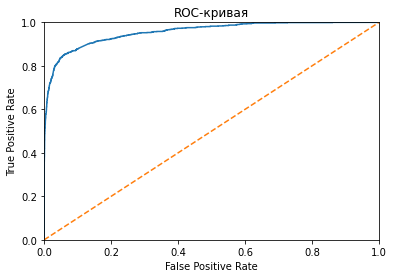

In [27]:
fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Выводы

При реализации проекта были осуществлены следующие этапы:

1) В результате подготовки данных был выявлен существенный дисбаланс классов. Одна треть текстовых данных датасета была токенизирована, проведена лемматизация и очистка этих данных с помощью модели "en_core_web_sm" из библиотеки SpaCy; <br/>
2) Были построены и обучены 3 модели классификации (LogisticRegression, CatBoostClassifier, LGBMClassifier).

В результате реализации проекта была найдена оптимальная модель LGBMClassifier по классификации комментариев на позитивные и негативные со значением метрики качества F1 более 0.75